In [26]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import seaborn as sns
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation
from keras.models import Sequential

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pylab as plt

In [6]:
dataset = pd.read_csv('../../data/cleaned/site1_malin.csv')
dataset.head()

,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],NH4 [mg/l],NO3 [mg/l],PO4 [mg/l],Chl tot [micro g/l],Chl cyano [micro g/l],Chl green Al. [micro g/l],turb [FTU],Secci Depth [m],pH
0,6/1/2016,0.0,20.8,127.3,748,0.877326755,0.162558848,0.012251796,39.8,3.2,36.6,5.1,0.8,8.63
1,6/1/2016,0.5,20.8,127.0,748,-,-,-,55.4,3.7,51.7,4.8,-,8.65
2,6/1/2016,1.0,20.4,131.4,756,-,-,-,45.6,3.0,42.6,4.9,-,8.66
3,6/1/2016,2.0,18.0,85.4,775,-,-,-,41.0,3.9,37.1,5.0,-,8.25
4,6/1/2016,3.0,15.8,4.0,786,1.050011213,0.270562171,0.031263202,54.6,5.8,48.8,5.8,-,7.89


In [7]:
df = dataset.drop(columns=['NH4 [mg/l]', 'NO3 [mg/l]', 'PO4 [mg/l]', 'Secci Depth [m]'])
df.head()

,date (mm.dd.yyyy),Depth [m],T [deg C],DO [%],SPC [micro S/cm],Chl tot [micro g/l],Chl cyano [micro g/l],Chl green Al. [micro g/l],turb [FTU],pH
0,6/1/2016,0.0,20.8,127.3,748,39.8,3.2,36.6,5.1,8.63
1,6/1/2016,0.5,20.8,127.0,748,55.4,3.7,51.7,4.8,8.65
2,6/1/2016,1.0,20.4,131.4,756,45.6,3.0,42.6,4.9,8.66
3,6/1/2016,2.0,18.0,85.4,775,41.0,3.9,37.1,5.0,8.25
4,6/1/2016,3.0,15.8,4.0,786,54.6,5.8,48.8,5.8,7.89


In [8]:
df.dtypes

date (mm.dd.yyyy)             object
Depth [m]                    float64
T [deg C]                    float64
DO [%]                       float64
SPC [micro S/cm]               int64
Chl tot [micro g/l]          float64
Chl cyano [micro g/l]        float64
Chl green Al. [micro g/l]    float64
turb [FTU]                   float64
pH                           float64
dtype: object

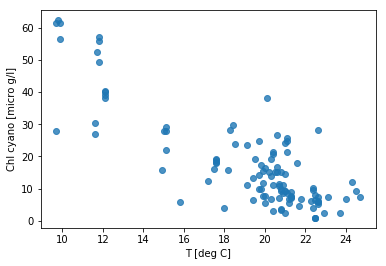

In [9]:
sns.regplot(x=df['T [deg C]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

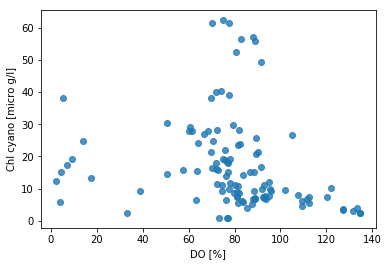

In [10]:
sns.regplot(x=df['DO [%]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

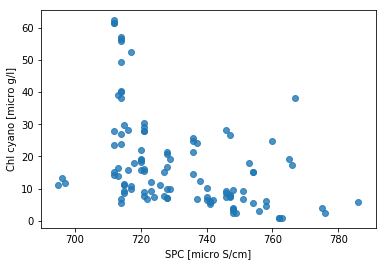

In [11]:
sns.regplot(x=df['SPC [micro S/cm]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

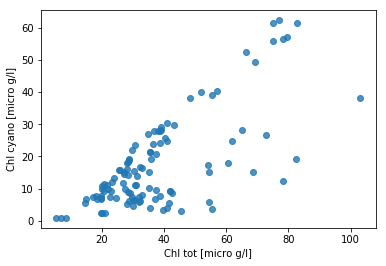

In [12]:
sns.regplot(x=df['Chl tot [micro g/l]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

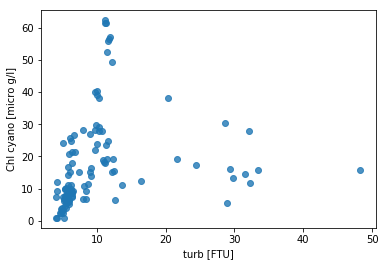

In [13]:
sns.regplot(x=df['turb [FTU]'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

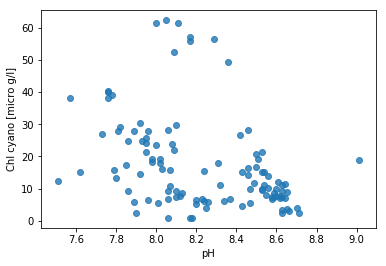

In [14]:
sns.regplot(x=df['pH'], y=df['Chl cyano [micro g/l]'], fit_reg=False)

In [15]:
df_train, df_test = train_test_split(df)
print(df.shape[0], df_train.shape[0], df_test.shape[0])

110 82 28


In [16]:
y_train = df_train['Chl cyano [micro g/l]'].values
y_test = df_test['Chl cyano [micro g/l]'].values

In [17]:
columns = ['Depth [m]', 'T [deg C]', 'DO [%]',
       'SPC [micro S/cm]', 'Chl tot [micro g/l]',
       'Chl green Al. [micro g/l]', 'turb [FTU]', 'pH']

### Null Model

In [18]:
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)
null_model = SGDRegressor(max_iter=3000)
null_model.fit(zeros_train, y_train)
predict_chl_test = null_model.predict(zeros_test)
null_mse = mean_squared_error(y_test, predict_chl_test)
null_rmse = np.sqrt(null_mse)

print("Null Model MSE:", null_mse)
print("Null Model RMSE:", null_rmse)

Null Model MSE: 371.58162444561964
Null Model RMSE: 19.2764525897692


In [20]:
for column in columns:
    x_train = df_train[[column]].values
    x_test = df_test[[column]].values
    
#     Use an imputer to replace any null values with 0 so that they are still counted
    imputer = SimpleImputer(missing_values=0)
    x_train_imputed = imputer.fit_transform(x_train)
    x_test_imputed = imputer.transform(x_test)
    
#     Use a scaler to normalize the data
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_imputed)
    x_test_scaled = scaler.transform(x_test_imputed)
    
    lr = SGDRegressor(max_iter=5000)
    lr.fit(x_train_scaled.reshape(-1, 1), y_train)
    predict_chl_test = lr.predict(x_test_scaled.reshape(-1, 1))
    lr_mse = mean_squared_error(y_test, predict_chl_test)
    lr_rmse = np.sqrt(lr_mse)
    
    print()
    print(column + " Model MSE:", lr_mse)
    print(column + " Model RMSE:", lr_rmse)


Depth [m] Model MSE: 391.05338390817593
Depth [m] Model RMSE: 19.775069757352966

T [deg C] Model MSE: 98.99278002613639
T [deg C] Model RMSE: 9.949511547113074

DO [%] Model MSE: 389.904464056228
DO [%] Model RMSE: 19.745998684701362

SPC [micro S/cm] Model MSE: 296.93670398899246
SPC [micro S/cm] Model RMSE: 17.231851438223128

Chl tot [micro g/l] Model MSE: 151.10171714143047
Chl tot [micro g/l] Model RMSE: 12.29234384246676

Chl green Al. [micro g/l] Model MSE: 375.69057048321974
Chl green Al. [micro g/l] Model RMSE: 19.382738983002884

turb [FTU] Model MSE: 363.9004516026175
turb [FTU] Model RMSE: 19.0761749730552

pH Model MSE: 348.1892891063063
pH Model RMSE: 18.659830897044763


In [21]:
sorted_columns = ['T [deg C]', 'pH', 'SPC [micro S/cm]', 'DO [%]', 'turb [FTU]', 'Depth [m]']
all_sorted_columns = ['T [deg C]', 'pH', 'Chl tot [micro g/l]', 'SPC [micro S/cm]', 'DO [%]', 'turb [FTU]', 'Depth [m]', 'Chl green Al. [micro g/l]']

In [24]:
base_model_columns = []
base_model = null_model
base_rmse = null_rmse
base_mse = null_mse

print("Null Model MSE:", null_mse)
print("Null Model RMSE:", null_rmse)

for column in all_sorted_columns:
    print("Base Model MSE:", base_mse)
    print("Base Model RMSE:", base_rmse)
    print()
    
    trial_columns = base_model_columns[:]
    trial_columns.append(column)
    
    x_train = df_train[trial_columns].values
    x_test = df_test[trial_columns].values
    
    imputer = SimpleImputer(missing_values=0)
    x_train_imputed = imputer.fit_transform(x_train)
    x_test_imputed = imputer.transform(x_test)
    
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_imputed)
    x_test_scaled = scaler.transform(x_test_imputed)
    
    trial_lr = SGDRegressor(max_iter=5000)
    trial_lr.fit(x_train_scaled, y_train)
    predict_chl_test = trial_lr.predict(x_test_scaled)
    trial_mse = mean_squared_error(y_test, predict_chl_test)
    trial_rmse = np.sqrt(trial_mse)
    
    print()
    print(str(trial_columns) + " Model MSE:", trial_mse)
    print(str(trial_columns) + " Model RMSE:", trial_rmse)
    
    if trial_rmse < base_rmse:
        print("Updating base model")
        base_rmse = trial_rmse
        base_mse = trial_mse
        base_model = trial_lr
        base_model_columns = trial_columns
    print()

Null Model MSE: 371.58162444561964
Null Model RMSE: 19.2764525897692
Base Model MSE: 371.58162444561964
Base Model RMSE: 19.2764525897692


['T [deg C]'] Model MSE: 98.99971513305661
['T [deg C]'] Model RMSE: 9.94986005595338
Updating base model

Base Model MSE: 98.99971513305661
Base Model RMSE: 9.94986005595338


['T [deg C]', 'pH'] Model MSE: 108.6259173351299
['T [deg C]', 'pH'] Model RMSE: 10.422375800897312

Base Model MSE: 98.99971513305661
Base Model RMSE: 9.94986005595338


['T [deg C]', 'Chl tot [micro g/l]'] Model MSE: 59.33182032214836
['T [deg C]', 'Chl tot [micro g/l]'] Model RMSE: 7.702715126638681
Updating base model

Base Model MSE: 59.33182032214836
Base Model RMSE: 7.702715126638681


['T [deg C]', 'Chl tot [micro g/l]', 'SPC [micro S/cm]'] Model MSE: 50.190243900498
['T [deg C]', 'Chl tot [micro g/l]', 'SPC [micro S/cm]'] Model RMSE: 7.084507315297091
Updating base model

Base Model MSE: 50.190243900498
Base Model RMSE: 7.084507315297091


['T [deg C]', 'Chl tot [mi

(0, 62.28635527006342)

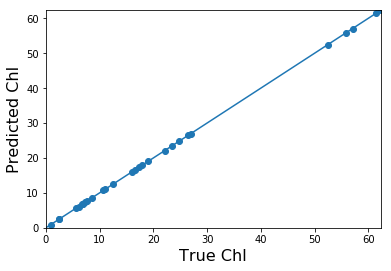

In [25]:
plt.scatter(y_test, predict_chl_test)
maximum = max(max(y_test), max(predict_chl_test))
plt.plot([0, maximum], [0, maximum])
plt.xlabel("True Chl", fontsize=16)
plt.ylabel("Predicted Chl", fontsize=16)
plt.xlim([0, max(y_test)])
plt.ylim([0, max(predict_chl_test)])